In [1]:
import pandas as pd
import torch

In [2]:
train_df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_df = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [3]:
train_df.shape, test_df.shape

((42000, 785), (28000, 784))

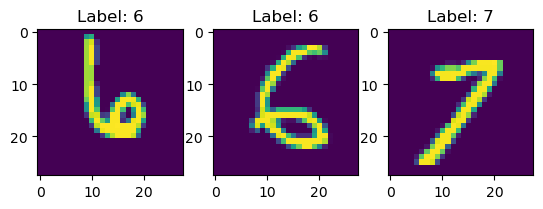

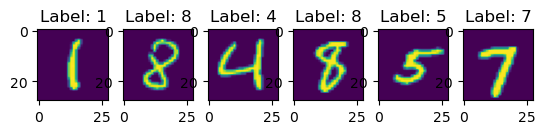

In [4]:
import matplotlib.pyplot as plt


def plot_image(df, indices):
    fig, ax = plt.subplots(1, len(indices))
    for i in range(len(indices)):
        ax[i].set_title(f'Label: {df.iloc[indices[i]].values[0]}')
        ax[i].imshow(df.iloc[indices[i]].values[1:].reshape(28, 28))
    
plot_image(train_df, [123, 127, 117])
plot_image(train_df, [1041, 3414, 4257, 1235, 7483, 14003])

In [5]:
from torch.utils.data import Dataset, DataLoader
from torch import tensor
import torch

    
def get_x(df):
    return tensor(df.values[:, 1:]).reshape(df.shape[0], 1, 28, 28).float()

class ImageDataset(Dataset):
    def __init__(self, df):
        self.X = get_x(df)
        self.Y = torch.zeros(10*df.shape[0]).reshape(df.shape[0], 10)
        for i in range(df.shape[0]):
            self.Y[i][df.iloc[i][0]] = 1
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, ind):
        return self.X[ind], self.Y[ind]
    

In [6]:
from torch import nn, optim
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_block = nn.Sequential(
            nn.LazyConv2d(32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
                        
            nn.LazyConv2d(64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            
            nn.LazyConv2d(128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),                        
        )
        
        self.linear_block = nn.Sequential(
            nn.Flatten(),
                        
            nn.LazyLinear(128),
            nn.ReLU(),
                        
            nn.LazyLinear(64),             
            nn.ReLU(),
            
            nn.LazyLinear(32),
            nn.ReLU(),
            
            nn.LazyLinear(10)
        )
    
    def forward(self, x):
        y = self.conv_block(x)
        return self.linear_block(x)

In [7]:
from sklearn.model_selection import train_test_split

def get_correct(df, model):
    x = get_x(df)
    y = model(x)
    predicted_classes = torch.argmax(y, dim=1)
    actual_classes = tensor(df.values[:, 0])
    return (actual_classes == predicted_classes).sum().item()

def train(df, p = 0.20):
    model = Net()        
    optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()
    epoch_count = 25
    
    if p > 0:
        train, test = train_test_split(df, test_size=p, random_state=42)
    else:
        train = df
        
    dataset = ImageDataset(train)
    dataloader = DataLoader(dataset, batch_size=32)
    
    for epoch in range(epoch_count):        
        correct = 0
        total = 0
        
        
        for batch in dataloader:
            x_tensor, y_tensor = batch        
            y_pred = model(x_tensor)
            loss = criterion(y_pred, y_tensor)

            assert not torch.isnan(loss)            

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()        
    
        
        print(epoch + 1)
        if p > 0:
            correct += get_correct(test, model)
            total = test.shape[0]
            print(f'Epoch: {epoch}, Accuracy: {round(100*correct / total, 2)}%')
            
    return model

In [8]:
model = train(train_df, 0)

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


In [9]:
x = tensor(test_df.values.reshape(test_df.shape[0], 1, 28, 28)).float()
y = model(x)
predicted_classes = torch.argmax(y, dim=1)
result = pd.DataFrame({'ImageId': test_df.index+1, 'Label': predicted_classes})
result.to_csv('sub.csv', index=False)